In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import model_selection
import xgboost as xgb

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [2]:
SALES_PATH = "../data/kc_house_data.csv"
DEMOGRAPHICS_PATH = "../data/zipcode_demographics.csv"
SALES_COLUMN_SELECTION = [
    "id", "date", "price", "bedrooms", "bathrooms",
    "sqft_living", "sqft_lot", "floors", "waterfront",
    "view", "condition", "grade", "sqft_above",
    "sqft_basement", "yr_built", "yr_renovated", "zipcode",
    "lat", "long", "sqft_living15", "sqft_lot15",
    'waterfront', 'view', 'grade', 'yr_built', 'yr_renovated', 'lat', 'long'
]

## Load training model

In [3]:
model = joblib.load("../model/model.pkl")
with open("../model/model_features.json", "r") as f:
    features = json.load(f)

### Load dataset

In [4]:
sales = pd.read_csv(SALES_PATH, usecols=SALES_COLUMN_SELECTION, dtype={'zipcode': str})
demographics = pd.read_csv(DEMOGRAPHICS_PATH, dtype={'zipcode': str})

# Merge on zipcode (same as training)
merged_data = sales.merge(demographics, how="left", on="zipcode").drop(columns="zipcode")
merged_data.isna().sum()

id                        0
date                      0
price                     0
bedrooms                  0
bathrooms                 0
sqft_living               0
sqft_lot                  0
floors                    0
waterfront                0
view                      0
condition                 0
grade                     0
sqft_above                0
sqft_basement             0
yr_built                  0
yr_renovated              0
lat                       0
long                      0
sqft_living15             0
sqft_lot15                0
ppltn_qty                 0
urbn_ppltn_qty            0
sbrbn_ppltn_qty           0
farm_ppltn_qty            0
non_farm_qty              0
medn_hshld_incm_amt       0
medn_incm_per_prsn_amt    0
hous_val_amt              0
edctn_less_than_9_qty     0
edctn_9_12_qty            0
edctn_high_schl_qty       0
edctn_some_clg_qty        0
edctn_assoc_dgre_qty      0
edctn_bchlr_dgre_qty      0
edctn_prfsnl_qty          0
per_urbn            

In [5]:
# Separate features and target
y = merged_data.pop("price")
x = merged_data[features]

print("Dataset shape:", x.shape)
x.head()

Dataset shape: (21613, 33)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,ppltn_qty,urbn_ppltn_qty,sbrbn_ppltn_qty,farm_ppltn_qty,non_farm_qty,medn_hshld_incm_amt,medn_incm_per_prsn_amt,hous_val_amt,edctn_less_than_9_qty,edctn_9_12_qty,edctn_high_schl_qty,edctn_some_clg_qty,edctn_assoc_dgre_qty,edctn_bchlr_dgre_qty,edctn_prfsnl_qty,per_urbn,per_sbrbn,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl
0,3,1.00,1180,5650,1.00,1180,0,"21,956.00","21,956.00",0.00,0.00,0.00,"47,461.00","22,158.00","175,400.00",925.00,"1,773.00","4,530.00","4,630.00","1,277.00","2,688.00",952.00,100.00,0.00,0.00,0.00,4.00,8.00,20.00,21.00,5.00,12.00,4.00
1,3,2.25,2570,7242,2.00,2170,400,"34,926.00","34,926.00",0.00,0.00,0.00,"42,400.00","25,771.00","225,900.00",776.00,"1,869.00","5,575.00","7,163.00","2,093.00","7,266.00","4,482.00",100.00,0.00,0.00,0.00,2.00,5.00,15.00,20.00,5.00,20.00,12.00
2,2,1.00,770,10000,1.00,770,0,"18,194.00","18,194.00",0.00,0.00,0.00,"61,813.00","31,765.00","246,600.00",269.00,905.00,"2,386.00","3,703.00","1,211.00","3,547.00","1,762.00",100.00,0.00,0.00,0.00,1.00,4.00,13.00,20.00,6.00,19.00,9.00
3,4,3.00,1960,5000,1.00,1050,910,"13,969.00","13,969.00",0.00,0.00,0.00,"56,455.00","39,232.00","280,200.00",186.00,459.00,"1,910.00","2,922.00","1,075.00","3,518.00","1,688.00",100.00,0.00,0.00,0.00,1.00,3.00,13.00,20.00,7.00,25.00,12.00
4,3,2.00,1680,8080,1.00,1680,0,"23,926.50","23,298.00",0.00,0.00,0.00,"56,933.00","27,639.50","239,850.00",406.00,"1,213.00","3,755.50","4,638.00","1,417.50","4,822.00","2,072.00",100.00,0.00,0.00,0.00,1.00,5.00,15.00,19.00,5.00,19.00,7.50


In [6]:
corr_matrix = x.corr()
corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().head(10)

bedrooms                bedrooms               1.00
ppltn_qty               urbn_ppltn_qty         0.98
                        edctn_assoc_dgre_qty   0.94
edctn_some_clg_qty      edctn_assoc_dgre_qty   0.94
edctn_prfsnl_qty        edctn_bchlr_dgre_qty   0.93
edctn_assoc_dgre_qty    urbn_ppltn_qty         0.92
medn_incm_per_prsn_amt  hous_val_amt           0.92
edctn_high_schl_qty     edctn_9_12_qty         0.91
ppltn_qty               edctn_some_clg_qty     0.91
edctn_less_than_9_qty   per_less_than_9        0.91
dtype: float64

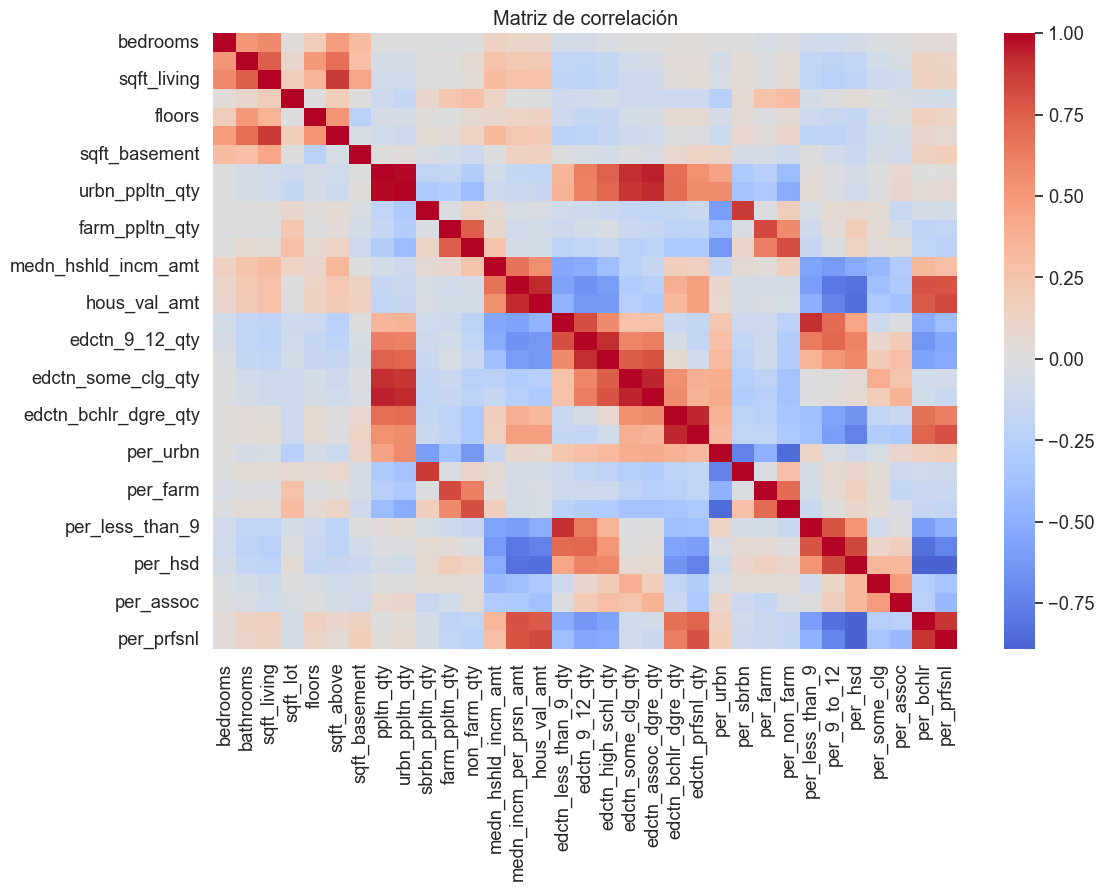

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de correlación")
plt.show()

In [8]:
threshold = 0.85
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)

high_corr = [(i, j, corr_pairs[i,j])
             for i in corr_matrix.columns
             for j in corr_matrix.columns
             if i != j and corr_matrix.loc[i,j] > threshold]

high_corr[:10]

[('sqft_living', 'sqft_above', 0.8765965986813202),
 ('sqft_above', 'sqft_living', 0.8765965986813202),
 ('ppltn_qty', 'urbn_ppltn_qty', 0.9843079550840722),
 ('ppltn_qty', 'edctn_some_clg_qty', 0.911582965602051),
 ('ppltn_qty', 'edctn_assoc_dgre_qty', 0.9416283905851526),
 ('urbn_ppltn_qty', 'ppltn_qty', 0.9843079550840722),
 ('urbn_ppltn_qty', 'edctn_some_clg_qty', 0.8951370110296393),
 ('urbn_ppltn_qty', 'edctn_assoc_dgre_qty', 0.9220489450566801),
 ('sbrbn_ppltn_qty', 'per_sbrbn', 0.8805140344993563),
 ('medn_incm_per_prsn_amt', 'hous_val_amt', 0.9207711476446544)]

## Predictions

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=42)

# Train predictions
y_train_pred = model.predict(x_train)

# Test predictions
y_test_pred = model.predict(x_test)

C:\Users\freww\miniconda3\envs\housing\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


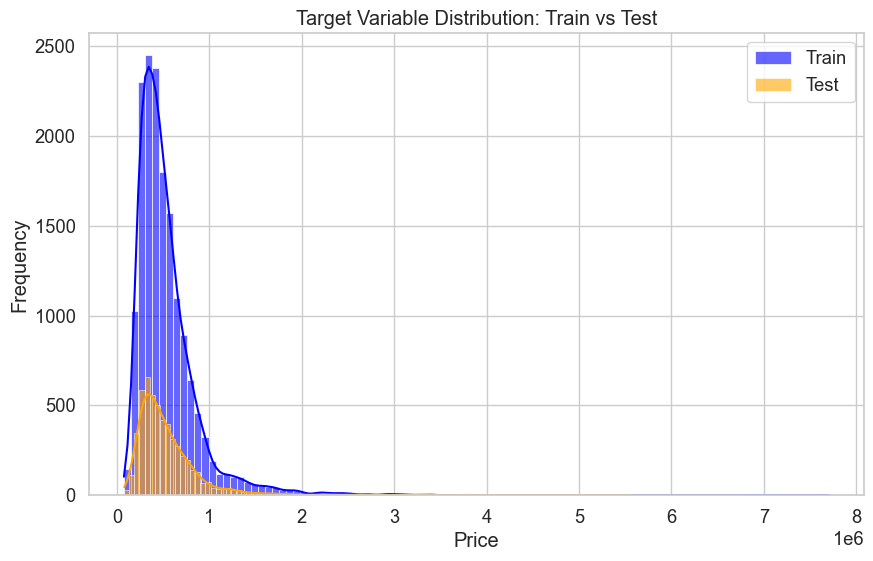

In [10]:
plt.figure(figsize=(10,6))

sns.histplot(y_train, bins=100, kde=True, color="blue", label="Train", alpha=0.6)
sns.histplot(y_test, bins=100, kde=True, color="orange", label="Test", alpha=0.6)

plt.title("Target Variable Distribution: Train vs Test")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [11]:
from scipy.stats import ks_2samp
import numpy as np

# --- KS Test ---
ks_stat, ks_pvalue = ks_2samp(y_train, y_test)
print("KS Test:")
print(f"  KS Statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pvalue:.4f}")

# --- PSI ---
def calculate_psi(expected, actual, buckets=10):
    """Calculate Population Stability Index (PSI) between two distributions."""
    def scale_range(input_array, min_val, max_val):
        return (input_array - np.min(input_array)) / (np.max(input_array) - np.min(input_array)) * (max_val - min_val) + min_val

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = np.percentile(expected, breakpoints)

    expected_counts = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_counts = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    psi = np.sum((expected_counts - actual_counts) * np.log((expected_counts + 1e-6) / (actual_counts + 1e-6)))
    return psi

psi_value = calculate_psi(y_train.values, y_test.values, buckets=10)
print("\nPopulation Stability Index (PSI):")
print(f"  PSI: {psi_value:.4f}")

KS Test:
  KS Statistic: 0.0184
  p-value: 0.1270

Population Stability Index (PSI):
  PSI: 0.0027


Interpretation

KS Test

If the p-value is high (> 0.05), there is no evidence that the distributions are different.

If the p-value is low (< 0.05), the distributions may differ significantly.

Population Stability Index (PSI)

< 0.1 → No change (distributions are very similar).

0.1 – 0.25 → Moderate change.

\> 0.25 → Significant change (potential distribution drift).

## Evaluation metrics

In [12]:
def regression_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# Comparizon train and test metrics
results = pd.DataFrame([
    regression_metrics(y_train, y_train_pred, "Training set"),
    regression_metrics(y_test, y_test_pred, "Test set")
])

results

,Model,RMSE,MAE,R²
0,Training set,"143,467.08","76,233.43",0.84
1,Test set,"201,659.37","102,044.01",0.73


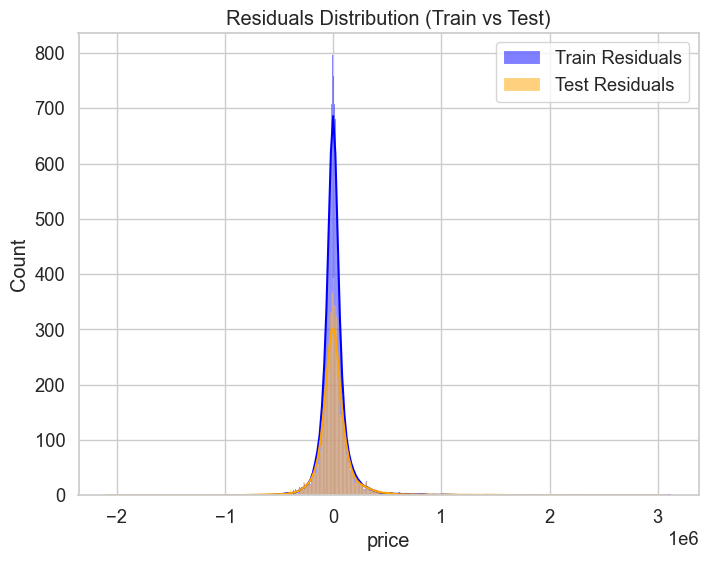

In [13]:
# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Residuals comparison
plt.figure(figsize=(8,6))
sns.histplot(train_residuals, color="blue", label="Train Residuals", kde=True)
sns.histplot(test_residuals, color="orange", label="Test Residuals", kde=True)
plt.legend()
plt.title("Residuals Distribution (Train vs Test)")
plt.show()

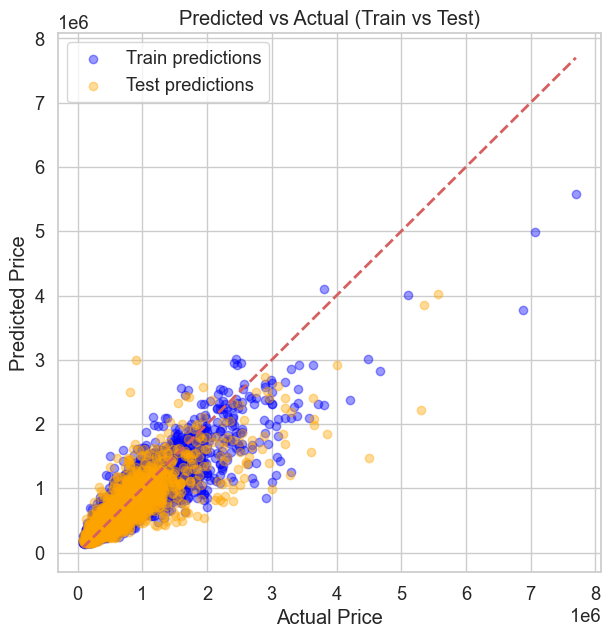

In [14]:
def plot_pred_vs_actual_combined(y_train, y_train_pred, y_test, y_test_pred, label1, label2, label3):
    plt.figure(figsize=(7,7))
    plt.scatter(y_train, y_train_pred, alpha=0.4, label=label1, color="blue")
    plt.scatter(y_test, y_test_pred, alpha=0.4, label=label2, color="orange")

    min_val = min(y_train.min(), y_test.min())
    max_val = max(y_train.max(), y_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", lw=2)

    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Predicted vs Actual {label3}")
    plt.legend()
    plt.show()

plot_pred_vs_actual_combined(y_train, y_train_pred, y_test, y_test_pred, "Train predictions", "Test predictions","(Train vs Test)")

In [15]:
def plot_residuals_vs_actual_combined(y_train, y_train_pred, y_test, y_test_pred, label1, label2, label3):
    plt.figure(figsize=(7,7))

    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    plt.scatter(y_train, residuals_train, alpha=0.4, label=label1, color="blue")
    plt.scatter(y_test, residuals_test, alpha=0.4, label=label2, color="orange")
    plt.axhline(y=0, color="red", linestyle="--", lw=2)

    plt.xlabel("Actual Price")
    plt.ylabel("Residuals (Error)")
    plt.title(f"Residuals vs Actual Price {label3}")
    plt.legend()
    plt.show()

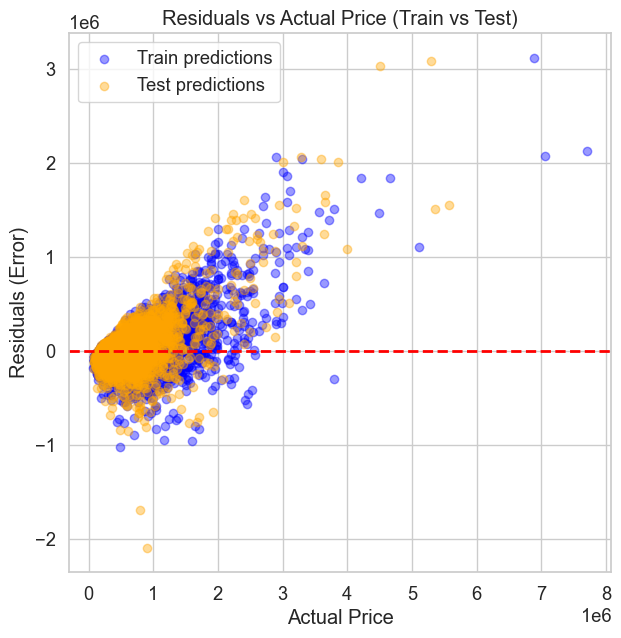

In [16]:
plot_residuals_vs_actual_combined(y_train, y_train_pred, y_test, y_test_pred, "Train predictions", "Test predictions", "(Train vs Test)" )

# XGBOOST

In [17]:
xgb_model = joblib.load("../model/xgb_model.pkl")
with open("../model/xgb_model_features.json", "r") as f:
    xgb_features = json.load(f)

In [18]:
x = merged_data[xgb_features]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=42)

In [19]:
# Predictions
y_train_pred_xgb = xgb_model.predict(x_train[xgb_features])
y_test_pred_xgb = xgb_model.predict(x_test[xgb_features])

In [20]:
lgb_model = joblib.load("../model/lgb_model.pkl")
with open("../model/lgb_model_features.json", "r") as f:
    lgb_features = json.load(f)

x = merged_data[lgb_features]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, random_state=42)

# Predictions
y_train_pred_lgb = lgb_model.predict(x_train[lgb_features])
y_test_pred_lgb = lgb_model.predict(x_test[lgb_features])

In [21]:
models_metrics = pd.DataFrame([
    regression_metrics(y_test, y_test_pred, "Base model"),
    regression_metrics(y_test, y_test_pred_xgb, "XGBoost model"),
    regression_metrics(y_test, y_test_pred_lgb, "LightGBM model")
])

models_metrics

,Model,RMSE,MAE,R²
0,Base model,"201,659.37","102,044.01",0.73
1,XGBoost model,"120,744.84","62,103.07",0.90
2,LightGBM model,"151,221.98","87,313.54",0.85


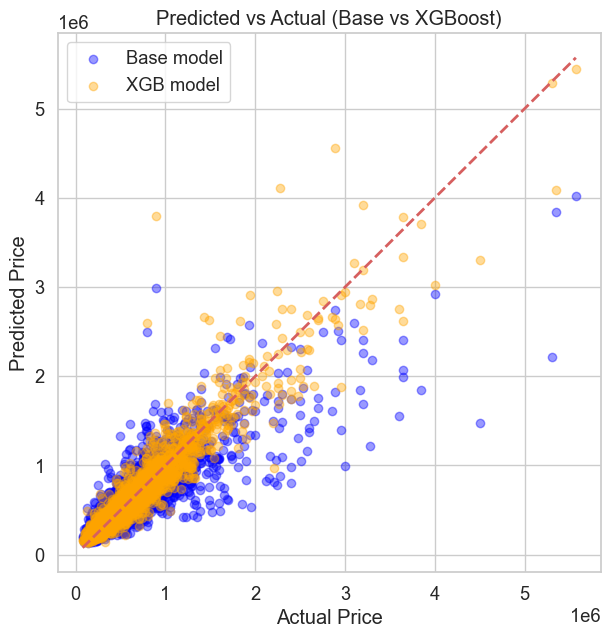

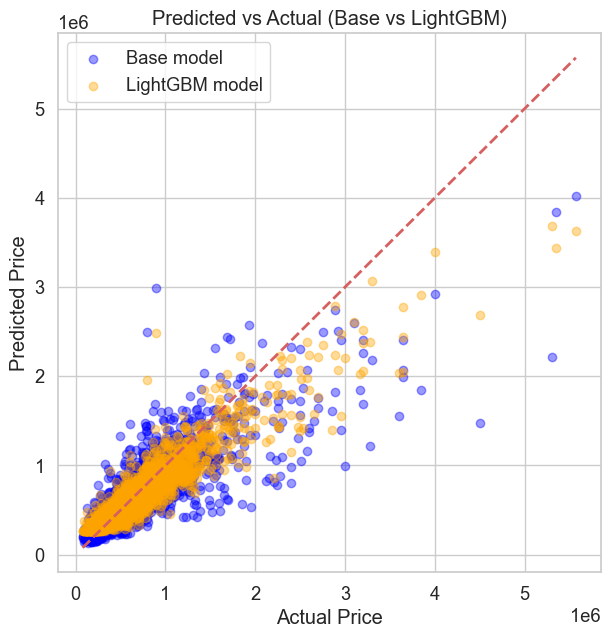

In [22]:
plot_pred_vs_actual_combined(y_test, y_test_pred, y_test, y_test_pred_xgb, "Base model", "XGB model","(Base vs XGBoost)")
plot_pred_vs_actual_combined(y_test, y_test_pred, y_test, y_test_pred_lgb, "Base model", "LightGBM model","(Base vs LightGBM)")

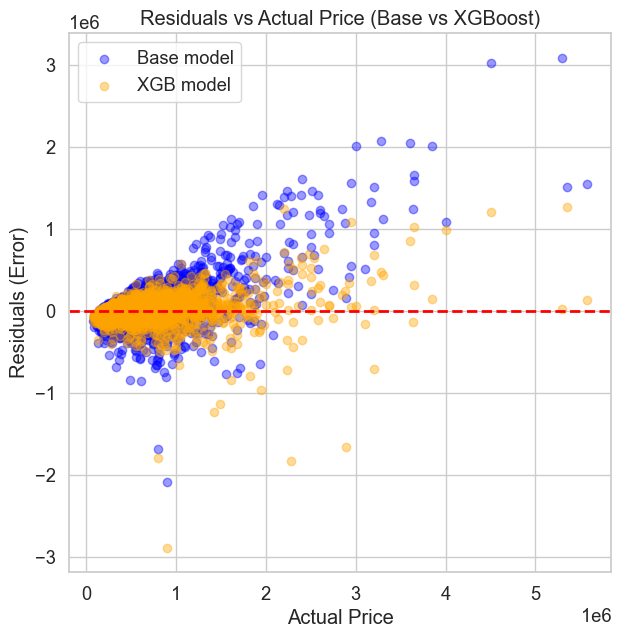

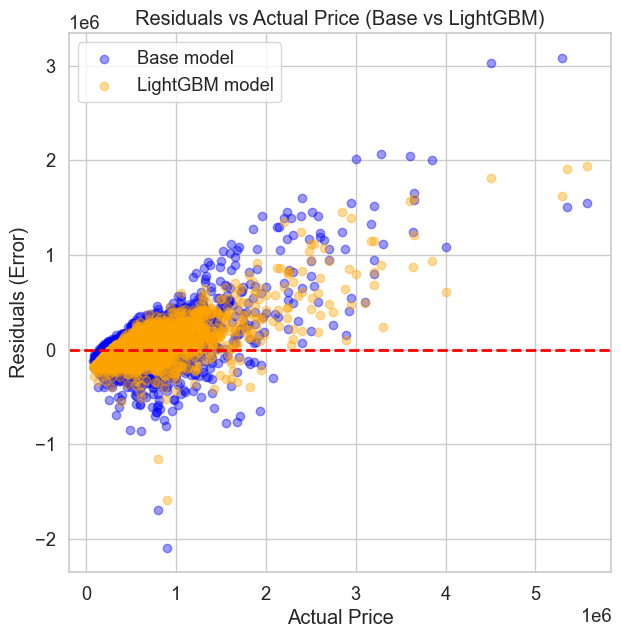

In [23]:
plot_residuals_vs_actual_combined(y_test, y_test_pred, y_test, y_test_pred_xgb, "Base model", "XGB model","(Base vs XGBoost)")
plot_residuals_vs_actual_combined(y_test, y_test_pred, y_test, y_test_pred_lgb, "Base model", "LightGBM model","(Base vs LightGBM)")

Feature importance:
                   feature  importance
7                    grade        0.20
31               per_bchlr        0.15
32              per_prfsnl        0.13
5               waterfront        0.12
2              sqft_living        0.07
19  medn_incm_per_prsn_amt        0.05
6                     view        0.04
1                bathrooms        0.03
27             per_9_to_12        0.02
12                     lat        0.02
8               sqft_above        0.02
28                 per_hsd        0.01
13                    long        0.01
17            non_farm_qty        0.01
21          edctn_9_12_qty        0.01
10                yr_built        0.01
11            yr_renovated        0.01
3                 sqft_lot        0.01
18     medn_hshld_incm_amt        0.01
9            sqft_basement        0.01
14               ppltn_qty        0.01
22    edctn_bchlr_dgre_qty        0.01
20   edctn_less_than_9_qty        0.01
29            per_some_clg        0.01
25   

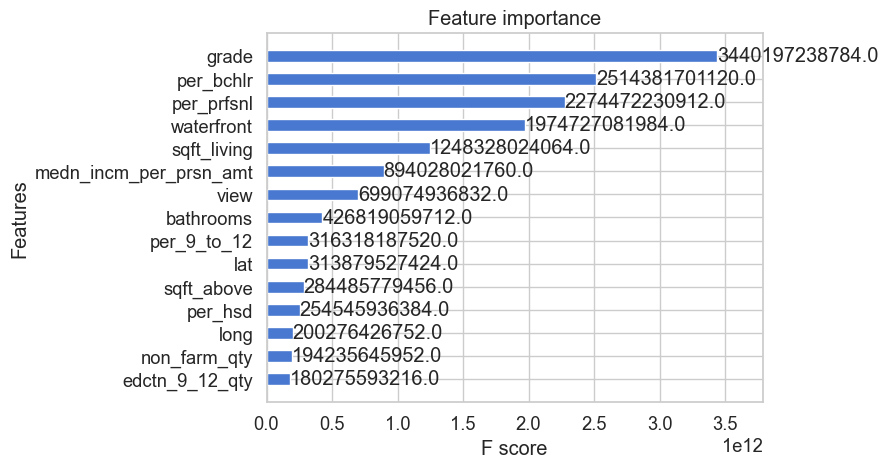

In [24]:
feature_importance = pd.DataFrame({
    'feature': xgb_model.feature_names_in_,
    'importance': xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("Feature importance:")
print(feature_importance)

xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15, height=0.5)
plt.show()